___
# Report classification using manually extracted (gold standard) annotations
___

In [1]:
import numpy as np
import pandas as pd
from utils.dataset import labels2cat
from utils import text, dev, eval_ml, prod
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

___
# Load reports

In [2]:
# Load the development set
df = pd.read_csv("../datasets/reports_dev.csv")

# Rename label column
df.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df.y = labels2cat(df.y)

# Define features
feature_names = prod.get_feature_names(['concepts', 'composite'])

# Add counts for gold standard annotations
df[feature_names] = text.get_concept_counts(df.histopathology_id, feature_names)

# Define features and labels
X = df[feature_names]
y = df.y.cat.codes
groups = df.patient_id

print("Using %d features." % X.shape[1])

df.y.value_counts()

Using 17 features.


y
Negative    199
Positive     32
Name: count, dtype: int64

___
# Model selection
### Quick&dirty trying a few algorithms

In [3]:
clfs = (
    LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced", random_state=42),
    MultinomialNB(),
)

for clf in clfs:
    dev.score_cv(clf, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
train time: 2.556s
Average precision score: 1.000 (+/- 0.00)
ROC AUC score: 1.000 (+/- 0.00)

________________________________________________________________________________
Training with 10-fold cross-validation:
MultinomialNB()
train time: 0.198s
Average precision score: 1.000 (+/- 0.00)
ROC AUC score: 1.000 (+/- 0.00)



### Tune the final model

In [4]:
clf = LogisticRegression(solver='saga', penalty='elasticnet', 
                         max_iter=5000, class_weight='balanced', random_state=42)

c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.5, 1, 10, 15, 20, 25, 30, 50]
l1_ratio = [1.0, 0.75, 0.5, 0.25, 0.0]
param_grid = {
    'C': c, 
    'l1_ratio': l1_ratio,
}

best_params = dev.search_params(clf, 'grid', param_grid, X, y, groups)
best_model = clf.set_params(**best_params)

Best for current fold: 1.000 using {'C': 0.1, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 1e-05, 'l1_ratio': 0.25}
0.975 (+/- 0.056) with: {'C': 1e-05, 'l1_ratio': 0.0}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 0.0001, 'l1_ratio': 0.25}
0.975 (+/- 0.056) with: {'C': 0.0001, 'l1_ratio': 0.0}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 1.0}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.75}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.5}
0.136 (+/- 0.069) with: {'C': 0.001, 'l1_ratio': 0.25}
0.977 (+/- 0.050) with: {'C': 0.001, 'l1_ratio': 0.0}
0.931 (+/- 0.187) with: {'C': 0.01, 'l1_ratio': 1.0}
0.972 (+/- 0.085) with: {'C': 0.01, 'l1_ratio': 0.75}
0.985 (+/

In [5]:
# best_model =  LogisticRegression(solver='saga', penalty='elasticnet', 
#                                  max_iter=5000, class_weight='balanced', random_state=42, 
#                                  C=0.1, l1_ratio=1.0)

___
# Model evaluation
### Evaluate the final model using CV

In [5]:
# Model performance in each CV fold
dev.score_cv(best_model, X, y, groups)

# Make predictions for each CV fold
y_proba = dev.predict_cv(best_model, X, y, groups)

________________________________________________________________________________
Training with 10-fold cross-validation:
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1.0, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')
train time: 0.371s
Average precision score: 1.000 (+/- 0.00)
ROC AUC score: 1.000 (+/- 0.00)



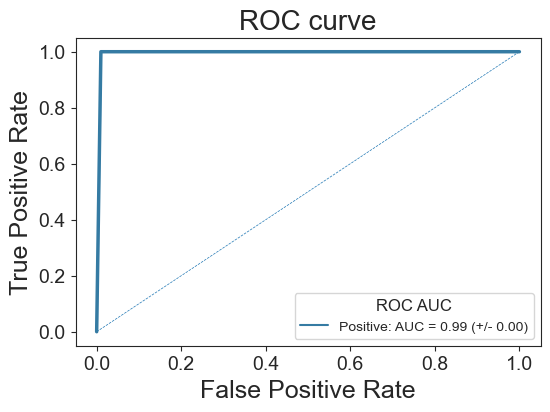

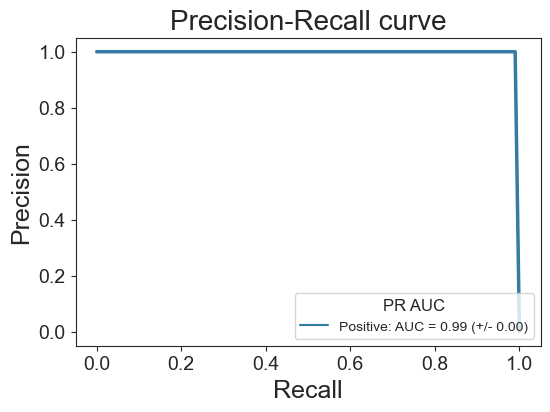

In [6]:
# Plot PR/ROC curves for each CV fold
eval_ml.plot_diagnostic_curves(df.set_index(['histopathology_id', 'val_fold']).y, y_proba, filename="gold_cv")

In [7]:
# Print optimal thresholds for each CV fold
dev.thresholds_cv(df.set_index('val_fold').y, y_proba[:,1])

# Find the optimal threshold using aggregated predictions
thresh = dev.find_optimal_threshold(y, y_proba[:,1])

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.998, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.967, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.998, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.488, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.998, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.594, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.561, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.395, F1-score = 1.000

The threshold optimises F1-score calculated from the PR curve.
Best threshold = 0.972, F1-score = 1.000

The threshold optimises F1-score calculated from the PR

Proportion of labels predicted as:
Negative    0.86
Positive    0.14
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       199
    Positive       1.00      1.00      1.00        32

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231

PPV: 1.00, Sensitivity: 1.00, Specificity: 1.00


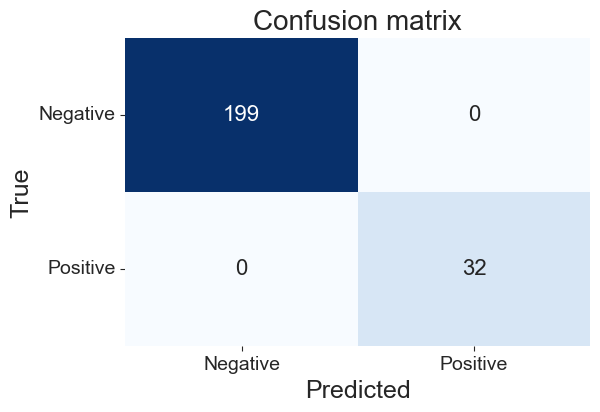

In [8]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification using aggregated predictions
eval_ml.evaluate_classification(df.y, y_pred)

### Train the final model on the full development set

In [9]:
# Re-train the final model on the full training set
best_model.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1.0, max_iter=5000,
                   penalty='elasticnet', random_state=42, solver='saga')

### Examine model coefficients

In [10]:
intercept = best_model.intercept_
coefs = best_model.coef_[0]
null_coef = (coefs == 0).sum()
print("The intercept = %.2f." % intercept[0])
print("%d coefficients are set to 0.0, %d features remaining:" % (null_coef, len(feature_names) - null_coef))
for ft, w in zip(feature_names, coefs):
    print('{0:30}  {1}'.format(ft, w.round(2)))

The intercept = -2.50.
15 coefficients are set to 0.0, 2 features remaining:
ClinicalQuery                   0.0
FungalDescriptor                0.09
Fungus                          0.0
Invasiveness                    0.0
Stain                           0.0
SampleType                      0.0
positive                        2.84
equivocal                       0.0
negative                        0.0
affirmedFungalDescriptor        0.0
affirmedFungus                  0.0
affirmedInvasiveness            0.0
affirmedStain                   0.0
negatedFungalDescriptor         0.0
negatedFungus                   0.0
negatedInvasiveness             0.0
negatedStain                    0.0


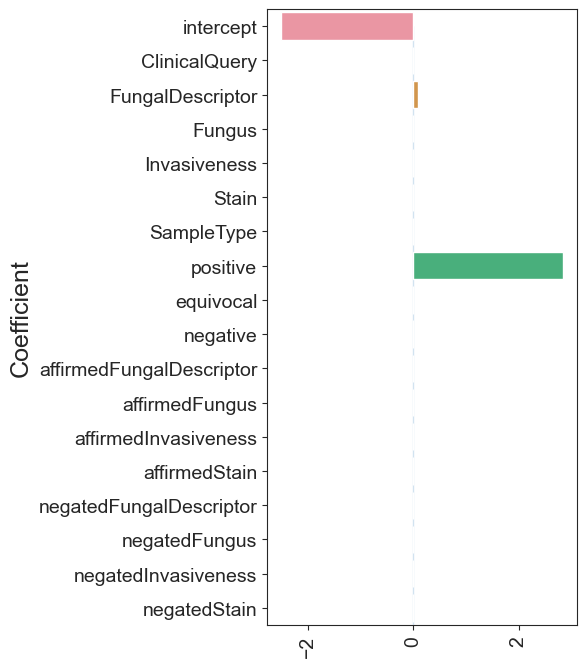

In [11]:
eval_ml.plot_coefficients(intercept, coefs, feature_names, filename="gold")

### Test the final model on test data

In [12]:
# Load the test set
df_test = pd.read_csv("../datasets/reports_test.csv")

# Rename label column
df_test.rename(columns={'y_report': 'y'}, inplace=True)

# Convert labels to categorical
df_test.y = labels2cat(df_test.y)

# Add counts for gold standard annotations
df_test[feature_names] = text.get_concept_counts(df_test.histopathology_id, feature_names)

# Define test set features and labels
X_test = df_test[feature_names]
y_test = df_test.y.cat.codes

# Make predictions
y_proba = best_model.predict_proba(X_test)

df_test.y.value_counts()

y
Negative    44
Positive     8
Name: count, dtype: int64

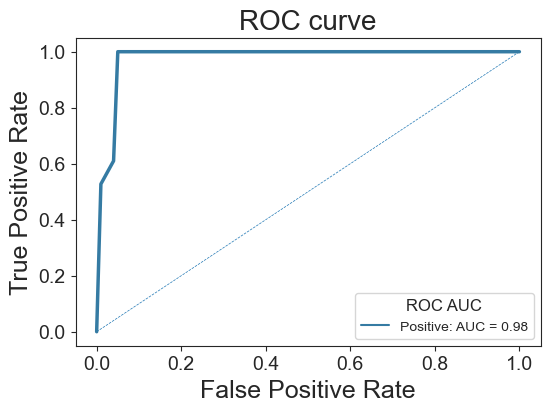

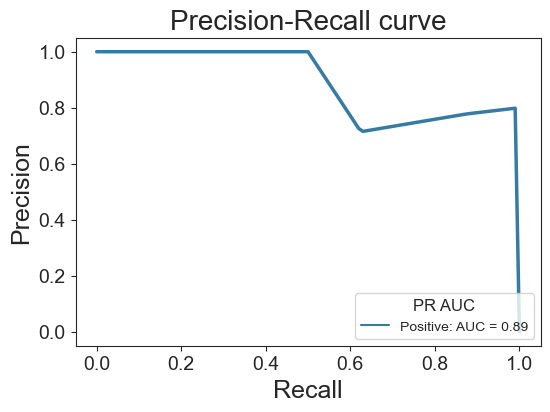

In [13]:
# Plot curves
eval_ml.plot_diagnostic_curves(df_test.set_index(['histopathology_id', 'val_fold']).y,
                               y_proba, filename="gold_test")

Proportion of labels predicted as:
Negative    0.81
Positive    0.19
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      0.95      0.98        44
    Positive       0.80      1.00      0.89         8

    accuracy                           0.96        52
   macro avg       0.90      0.98      0.93        52
weighted avg       0.97      0.96      0.96        52

PPV: 0.80, Sensitivity: 1.00, Specificity: 0.95


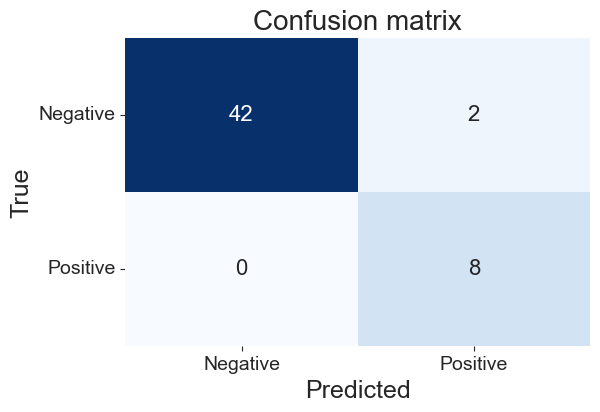

In [14]:
# Convert probabilities to class labels
y_pred = prod.proba2class(y_proba, thresh)

# Evaluate classification
eval_ml.evaluate_classification(df_test.y, y_pred, filename="gold_test")